This script uses the data in the GBM_data folder to predict segmentation of test images https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial


### Data Preparation

In [ ]:
!pip install -U scikit-learn
#run once for jaccard_score

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
%cd /content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet

Mounted at /content/drive/
/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet


In [ ]:
# Imports
import pathlib
import torch
from transformations import (
    ComposeDouble,
    normalize_01,
    AlbuSeg2d,
    FunctionWrapperDouble,
    create_dense_target,
)
from sklearn.model_selection import train_test_split
from customdatasets3 import SegmentationDataSet3
import torch
import numpy as np
from unet import UNet
from trainer import Trainer
from torch.utils.data import DataLoader
from skimage.transform import resize
import albumentations

# root directory
root = pathlib.Path.cwd()/"GBM_data" 

def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return sorted(filenames)

# for some reason the augmented data is (0,255) and won't normalize...
# input and target files
inputs = get_filenames_of_path(root / "Input")
targets = get_filenames_of_path(root / "Target")

print(inputs)
print(targets)

# constants
channel_dims = 1
out_shape = 512

# pre-transformations
pre_transforms = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(out_shape, out_shape, channel_dims) #3
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(out_shape, out_shape),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
    ]
)

# training transformations and augmentations
transforms_training = ComposeDouble(
    [
        AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# validation transformations
transforms_validation = ComposeDouble(
    [
        FunctionWrapperDouble(
            resize, input=True, target=False, output_shape=(out_shape, out_shape, channel_dims) #3
        ),
        FunctionWrapperDouble(
            resize,
            input=False,
            target=True,
            output_shape=(out_shape, out_shape),
            order=0,
            anti_aliasing=False,
            preserve_range=True,
        ),
        FunctionWrapperDouble(create_dense_target, input=False, target=True),
        FunctionWrapperDouble(
            np.moveaxis, input=True, target=False, source=-1, destination=0
        ),
        FunctionWrapperDouble(normalize_01),
    ]
)

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs, random_state=random_seed, train_size=train_size, shuffle=True
)

targets_train, targets_valid = train_test_split(
    targets, random_state=random_seed, train_size=train_size, shuffle=True
)

# inputs_train, inputs_valid = inputs[:80], inputs[80:]
# targets_train, targets_valid = targets[:80], targets[:80]

# dataset training
dataset_train = SegmentationDataSet3(
    inputs=inputs_train,
    targets=targets_train,
    transform=transforms_training,
    use_cache=True,
    pre_transform=pre_transforms,
)

# dataset validation
dataset_valid = SegmentationDataSet3(
    inputs=inputs_valid,
    targets=targets_valid,
    transform=transforms_validation,
    use_cache=True,
    pre_transform=pre_transforms,
)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, batch_size=1, shuffle=True)

[PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Input/1.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Input/10.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Input/100.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Input/101.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Input/102.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Input/103.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Input/104.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Input/105.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Input/106.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Input/107.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel

### Pre-Training Check

In [ ]:
x, y = next(iter(dataloader_training))

print(f"x = shape: {x.shape}; type: {x.dtype}")
print(f"x = min: {x.min()}; max: {x.max()}")
print(f"y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}")

x = shape: torch.Size([1, 1, 512, 512]); type: torch.float32
x = min: 0.0; max: 1.0
y = shape: torch.Size([1, 512, 512]); class: tensor([0, 1]); type: torch.int64


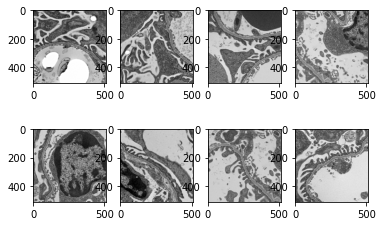

In [ ]:
#visualize some data as sanity check
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.io import imread
for i in range(0,8): 
  image = imread(inputs_train[i]) #inputs_train, inputs_valid, targets_train, or targets_valid
  plt.subplot(2,4,i+1)
  plt.imshow(image)
  plt.gray()

In [ ]:
from unet import UNet

model = UNet(
    in_channels=1,
    out_channels=2,
    n_blocks=4,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
)

x = torch.randn(size=(1, 1, 512, 512), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f"Out: {out.shape}")

Out: torch.Size([1, 2, 512, 512])


In [ ]:
#view model
from torchsummary import summary
summary = summary(model, (1, 512, 512), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
              ReLU-2         [-1, 32, 512, 512]               0
       BatchNorm2d-3         [-1, 32, 512, 512]              64
            Conv2d-4         [-1, 32, 512, 512]           9,248
              ReLU-5         [-1, 32, 512, 512]               0
       BatchNorm2d-6         [-1, 32, 512, 512]              64
         MaxPool2d-7         [-1, 32, 256, 256]               0
         DownBlock-8  [[-1, 32, 256, 256], [-1, 32, 512, 512]]               0
            Conv2d-9         [-1, 64, 256, 256]          18,496
             ReLU-10         [-1, 64, 256, 256]               0
      BatchNorm2d-11         [-1, 64, 256, 256]             128
           Conv2d-12         [-1, 64, 256, 256]          36,928
             ReLU-13         [-1, 64, 256, 256]               0
      BatchNorm2d-14    

### Training

#### Hyper-Parameters

In [ ]:
#train
nums_epochs = 20
cross_entropy_weight = 0.06
fit_steps = 500

# device
device = torch.device('cuda')

#### Training

In [ ]:
# model
model = UNet(in_channels=channel_dims, #3
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# criterion
weights = [1, cross_entropy_weight]
class_weights = torch.FloatTensor(weights).cuda()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #learning rate

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=nums_epochs,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/320 [00:00<?, ?it/s]

Validation:   0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
# save the model
model_name = "membrane_model_" + str(nums_epochs) + "epochs.pt"
torch.save(model.state_dict(), pathlib.Path.cwd() / model_name)

Progress: 100%|██████████| 2/2 [00:41<00:00, 20.72s/it]


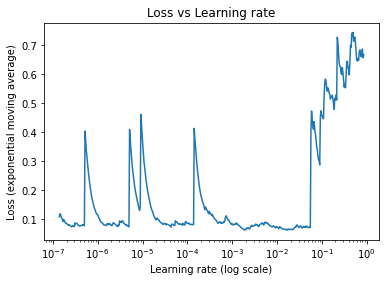

In [ ]:
#find best learning rate
from lr_rate_finder import LearningRateFinder

lrf = LearningRateFinder(model, criterion, optimizer, device)
lrf.fit(dataloader_training, steps=fit_steps)
lrf.plot()

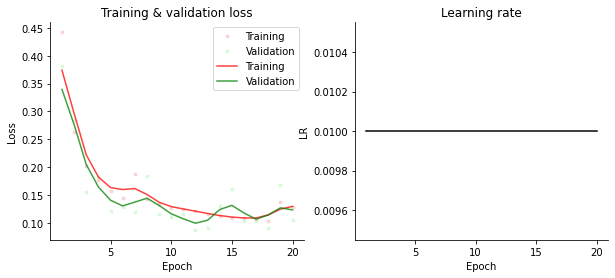

In [ ]:
from visual import plot_training

fig = plot_training(
    training_losses,
    validation_losses,
    lr_rates,
    gaussian=True,
    sigma=1,
    figsize=(10, 4),
)

In [ ]:
#predict
from skimage.io import imread
from skimage.transform import resize
from inference import predict
from transformations import normalize_01, re_normalize

# root directory
root = pathlib.Path.cwd() / "GBM_data" / "Test"

def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return sorted(filenames)

# input and target files
images_names = get_filenames_of_path(root / "Input")
targets_names = get_filenames_of_path(root / "Target")

print(images_names)
print(targets_names)


# read images and store them in memory
images = [imread(img_name) for img_name in images_names]
targets = [imread(tar_name) for tar_name in targets_names]

# Resize images and targets
images_res = [resize(img, (out_shape, out_shape, channel_dims)) for img in images] #3
resize_kwargs = {"order": 0, "anti_aliasing": False, "preserve_range": True}
targets_res = [resize(tar, (out_shape, out_shape), **resize_kwargs) for tar in targets]

# device
device = torch.device('cuda')

# model_name = "membrane_model_300epochs.pt"
model_weights = torch.load(pathlib.Path.cwd() / model_name, map_location=device)
model.load_state_dict(model_weights)

# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img

# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img

output = [predict(img, model, preprocess, postprocess, device) for img in images_res]

[PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Test/Input/401.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Test/Input/402.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Test/Input/403.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Test/Input/404.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Test/Input/405.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Test/Input/406.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Test/Input/407.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Test/Input/408.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Test/Input/409.png'), PosixPath('/content/drive/Shareddrives/SeniorDesignGroup/Aksel_Unet/GBM_data/Test/Input/410.png'), PosixPath

### Results Check

Output Shape:  (512, 512)
225.0578498840332


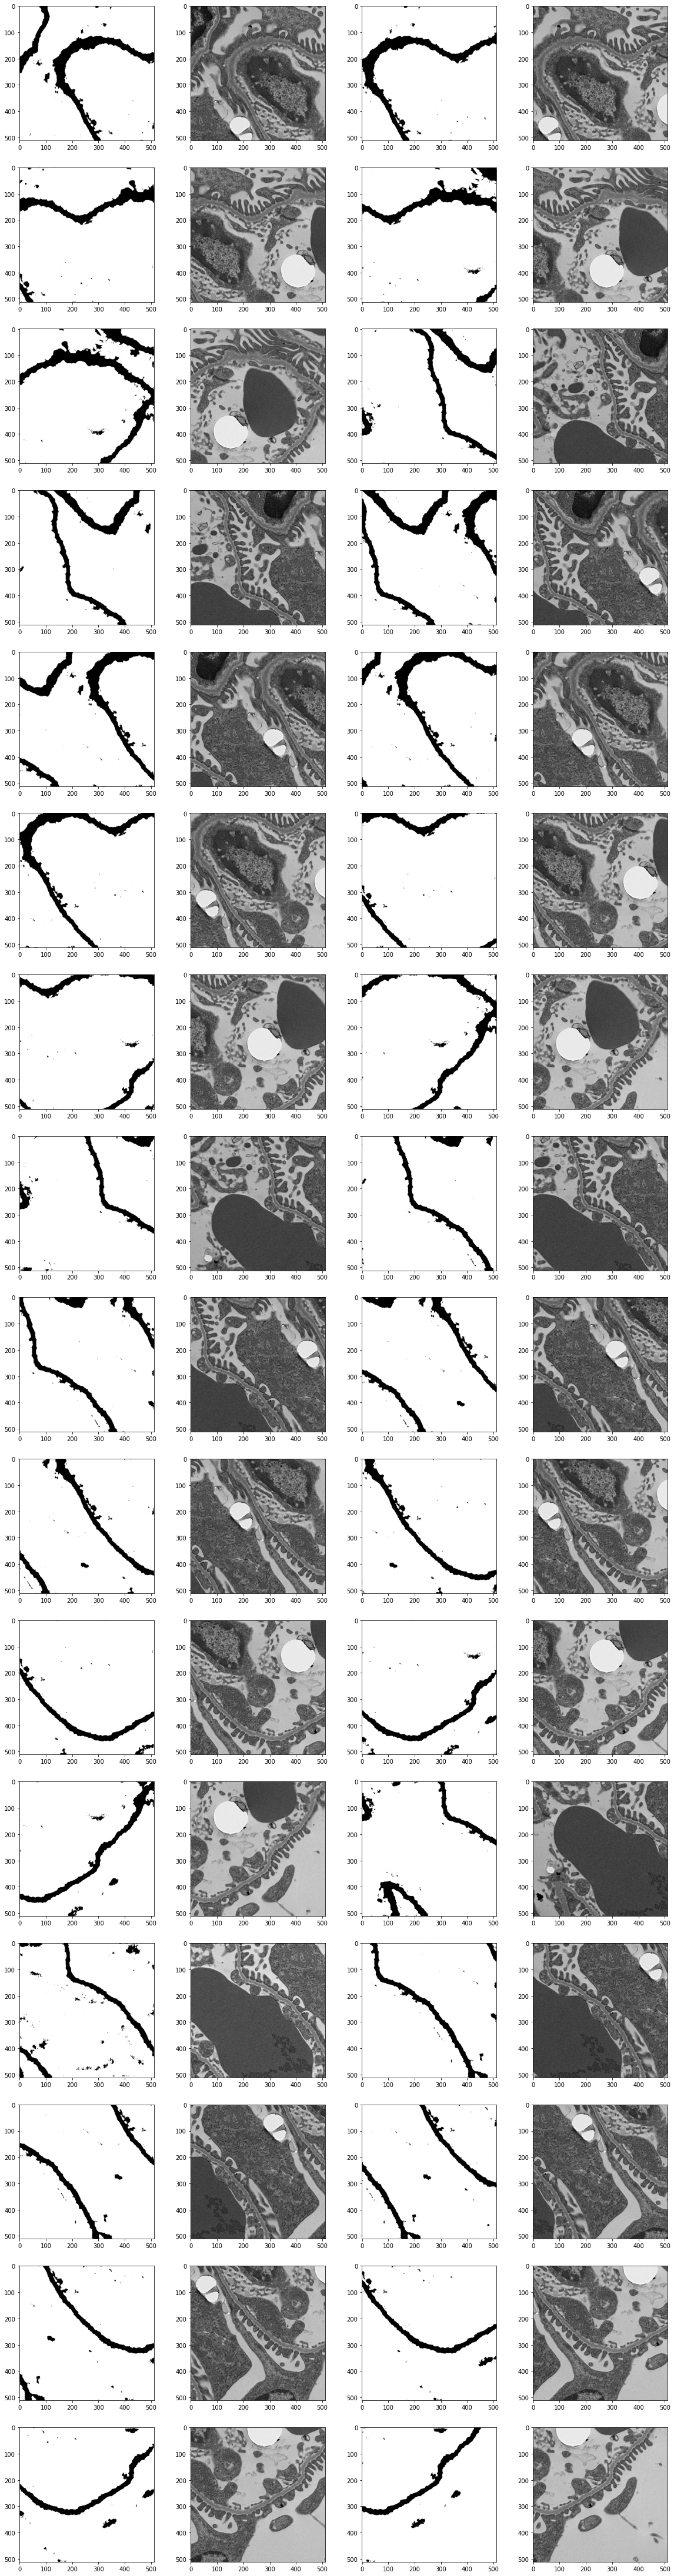

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(20, 80))

print("Output Shape: ", output[0].shape)
print(output[0].mean())

r = 8
c = 4
for i in range(0,r*c): #96
  predicted = output[i]
  plt.subplot(r*2,c,i*2+1)
  plt.imshow(predicted)
  plt.subplot(r*2,c,i*2+2)
  if channel_dims == 3:
    plt.imshow(images_res[i])
  else:
    plt.imshow(images_res[i][:,:,0])

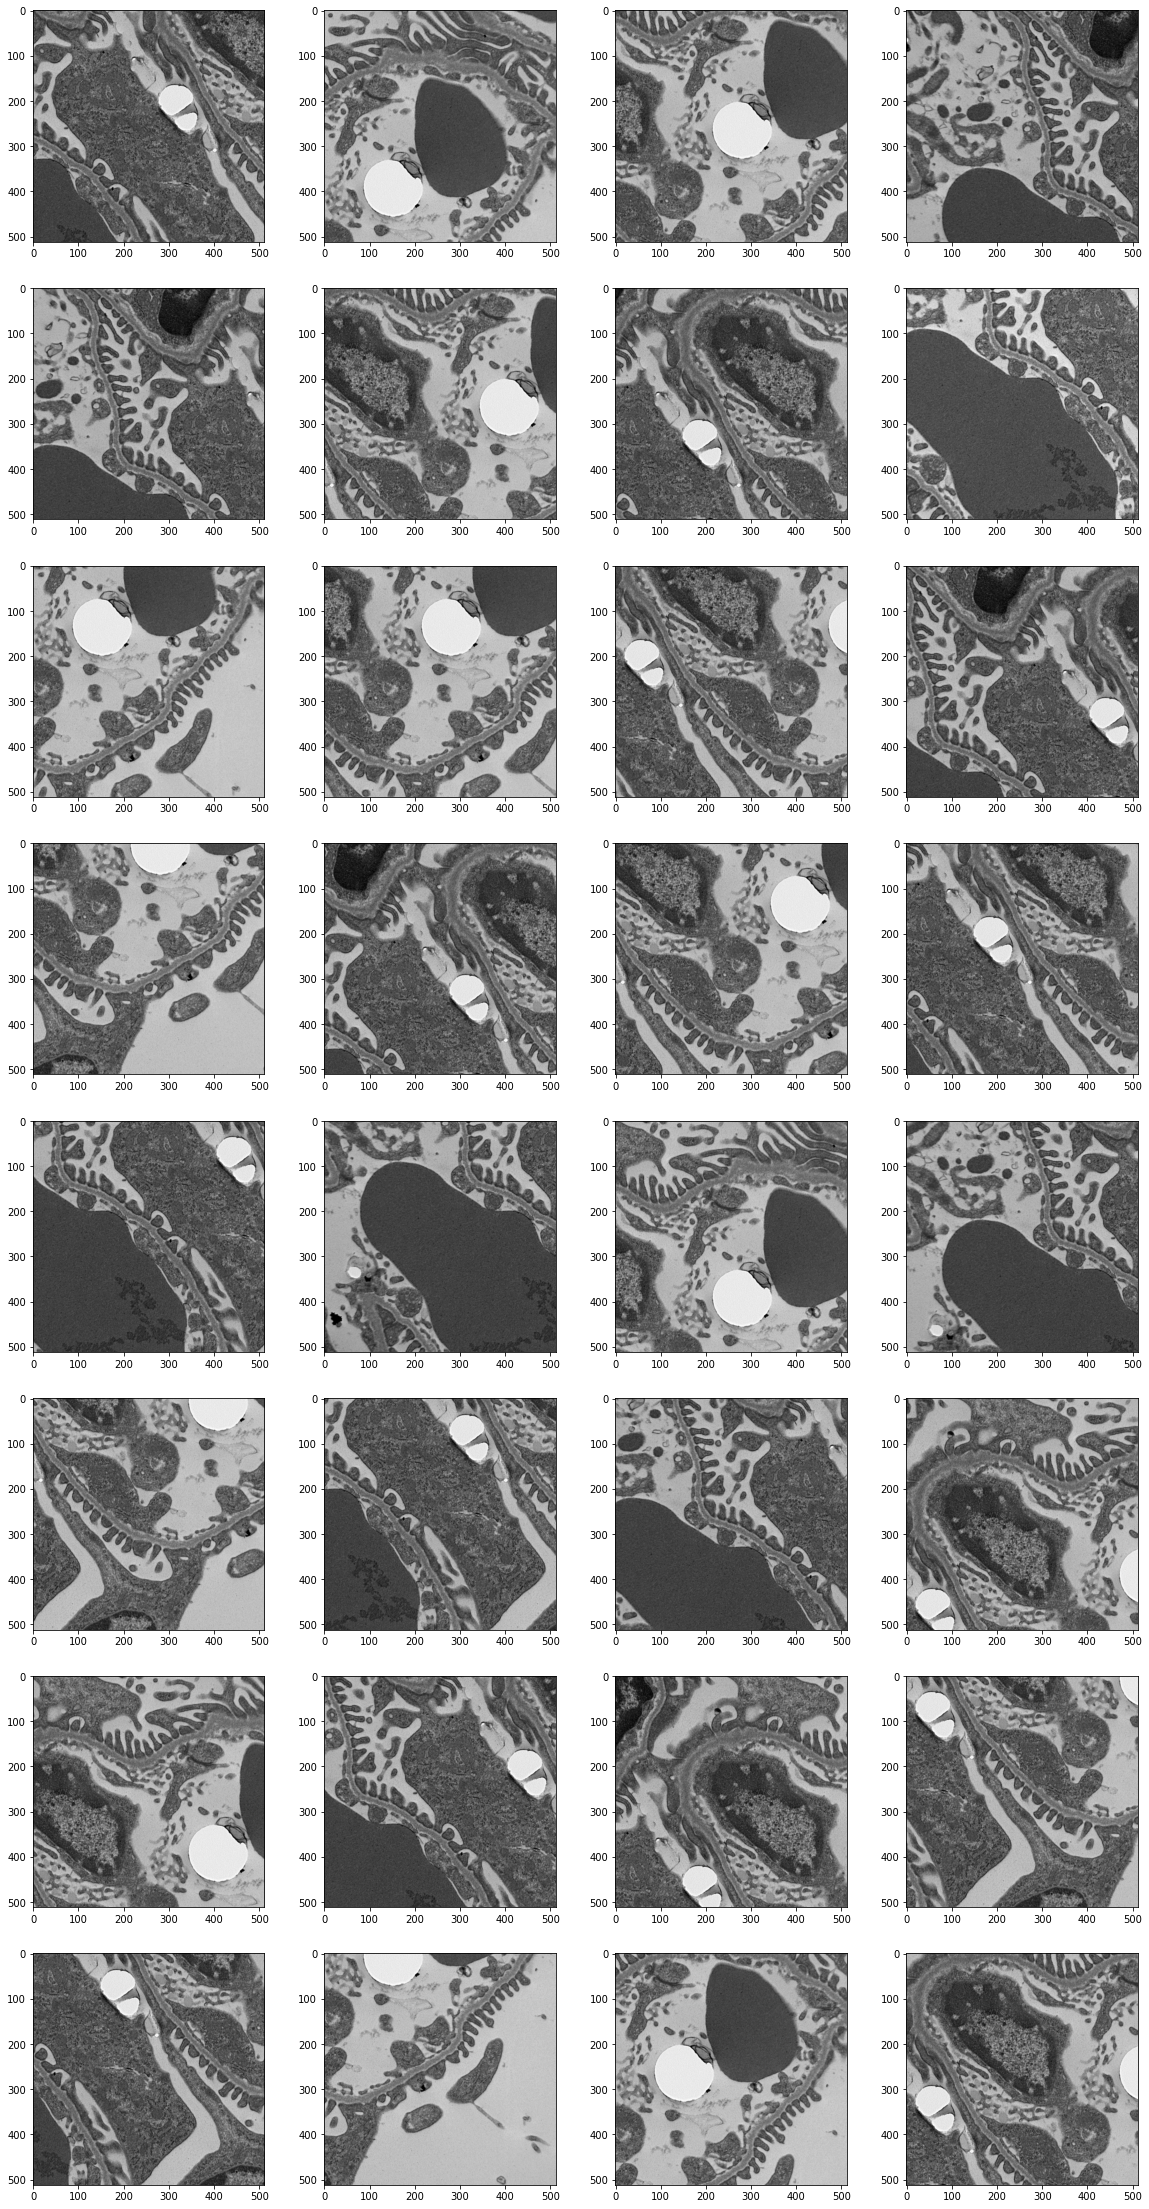

In [ ]:
figure(figsize=(20, 40))

for i in range(0,32):
    plt.subplot(8,4,i+1)
    if channel_dims == 3:
      plt.imshow(images_res[i])
    else:
      plt.imshow(images_res[i][:,:,0])

The mean Jaccard index for test images is 0.9396727712738185


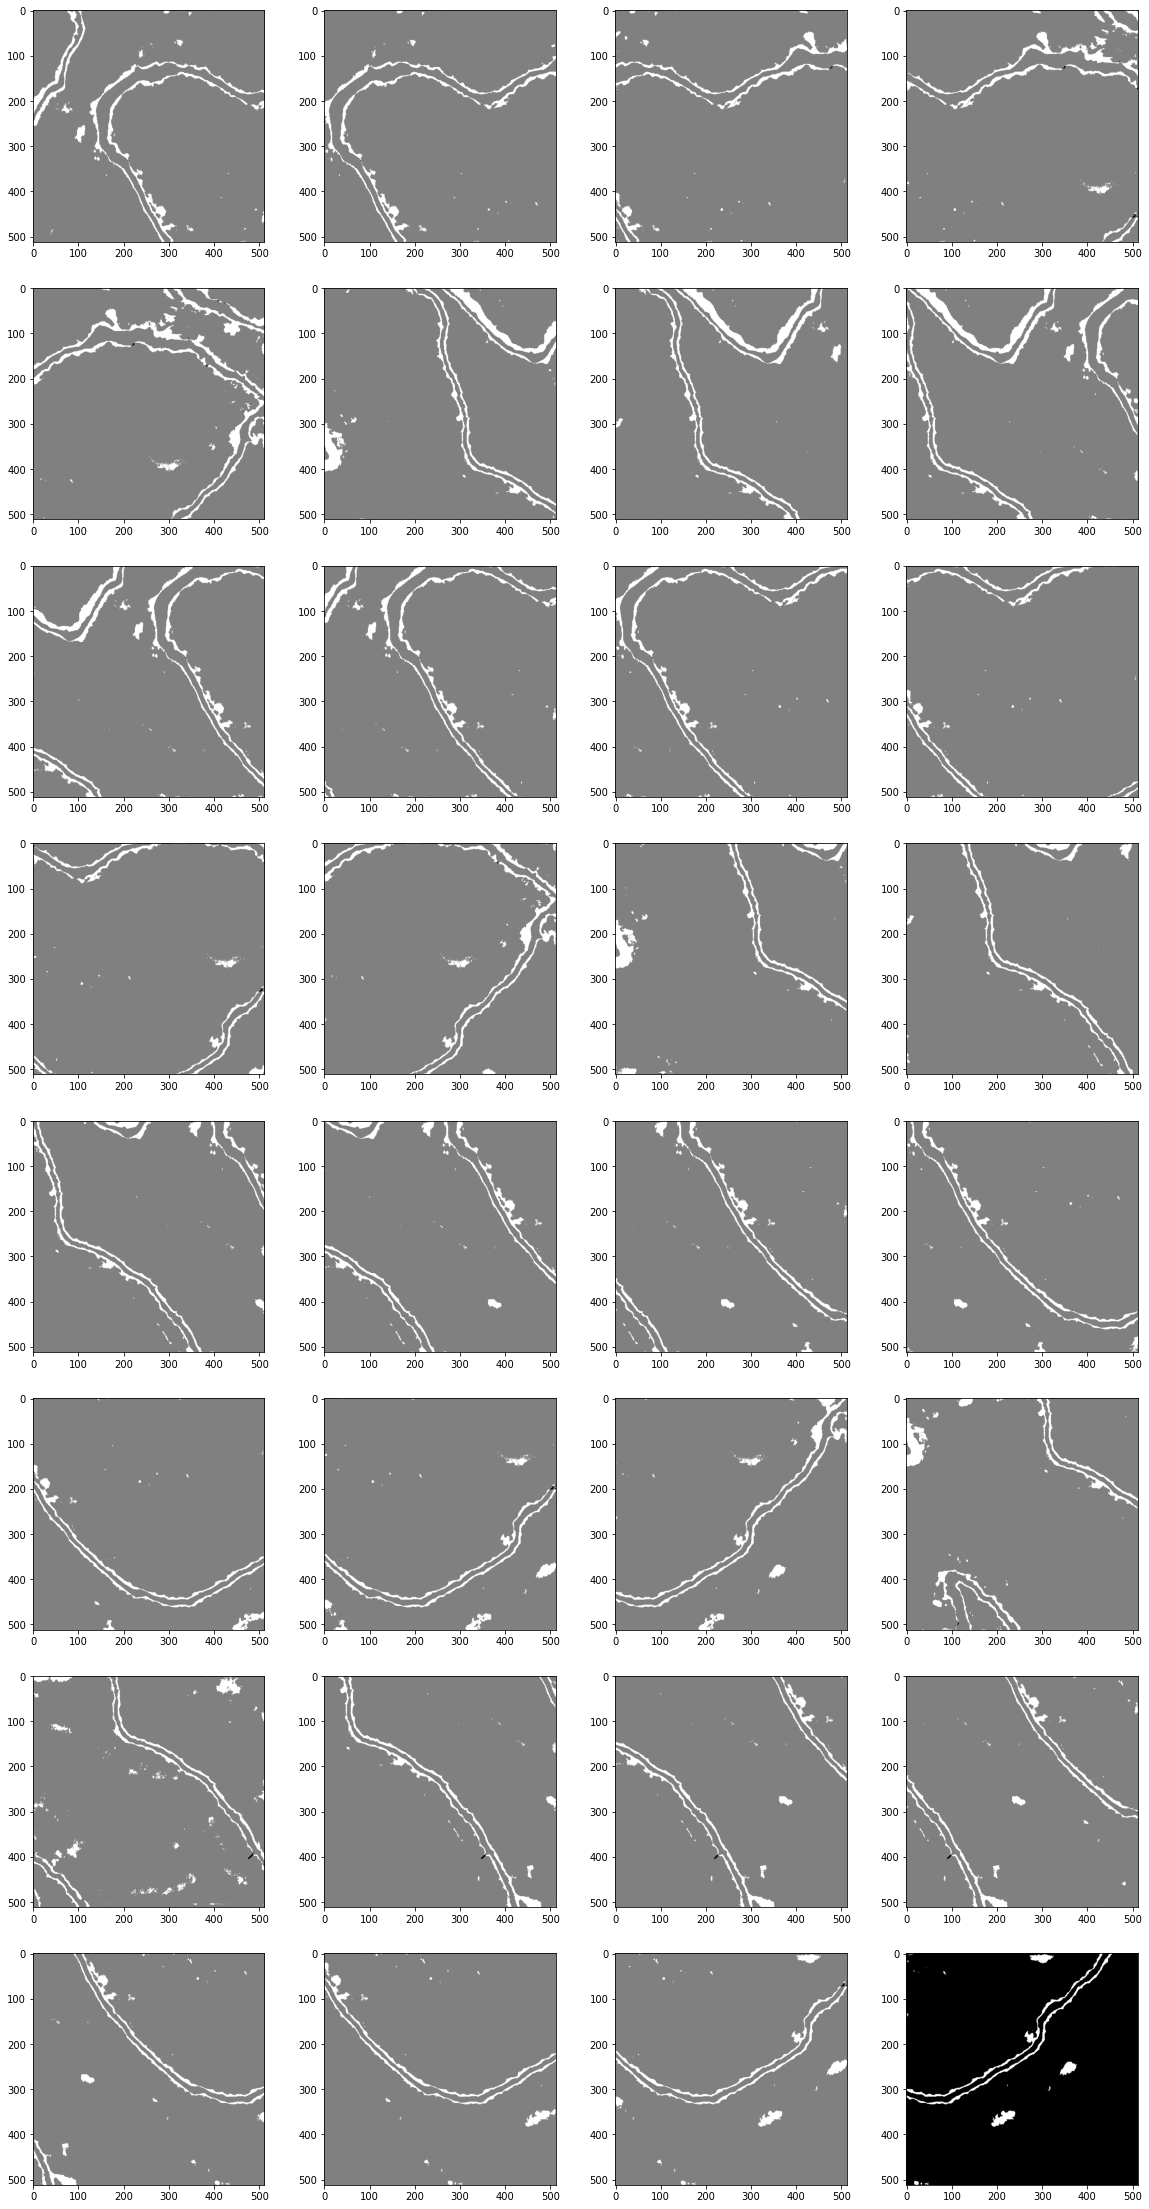

In [ ]:
#visualize discrepancy between predicted and ground truth annotation
from sklearn.metrics import jaccard_score
from numpy import mean
jaccard = []
figure(figsize=(20, 40))
for i in range(0,32):
    plt.subplot(8,4,i+1)
    plt.imshow(targets_res[i] - output[i]) 
    # plt.imshow(targets_res[i]) 
for i in range(0,10):
    jaccard.append(jaccard_score(targets_res[i], output[i], labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn'))
print(f'The mean Jaccard index for test images is', mean(jaccard))